Compare predicted and empirical SAR by scaling down to whatever scales are easily divisible by 30, so that we use every cell at every scale.

In [1]:
import numpy as np
import pandas as pd
import sar # This is our custom function
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import data
df = pd.read_csv('./RawData/IndividualPitfalls.csv')

# Get land use types
lu = df['Habitat (general)'].unique()
lu_nsites = np.zeros(len(lu),dtype=int)
for i,l in enumerate(lu):
    lu_nsites[i] = df['Site code'].loc[df['Habitat (general)']==l].nunique()
    print("Land use and number of sites:   {}\t{}".format(l,lu_nsites[i]))
    
# Get list of sites
ls = df['Site code'].unique()

# Get list of habitats that these sites correspond to
lu_ls = []
for i,s in enumerate(ls):
    # Get habitat type
    hb = df[df['Site code'] == s]['Habitat (general)'].unique()
    # Throw an error if the length of this isn't one, as the site has more than one habitat assigned to it.
    if len(hb) != 1:
        print("RUH ROH!")
    else:
        lu_ls.append(hb[0])
lu_ls = np.array(lu_ls)
    
# Get the unique sample codes and sort this list.
sc = np.sort(df['Sample number'].unique())

# Get all mf codes
mf = df['MF'].unique()

Land use and number of sites:   Exotic forest - mono	12
Land use and number of sites:   Native vegetation	44
Land use and number of sites:   Pasture - intensive	24
Land use and number of sites:   Pasture - semi-natural	10


In [3]:
# Print n0/s0 across sites. Note that n0/s0 is much higher for pasture sites!
for l in lu:
    print(l)
    n0l = df[df['Habitat (general)']==l]['Adults'].sum()
    s0l = df[df['Habitat (general)']==l]['MF'].nunique()
    print("N0",n0l)
    print("S0",s0l)
    print("log(N0/S0)",np.log(n0l/s0l))
    print()

Exotic forest - mono
N0 2648
S0 83
log(N0/S0) 3.462719309260301

Native vegetation
N0 4198
S0 115
log(N0/S0) 3.5974313720173283

Pasture - intensive
N0 19389
S0 128
log(N0/S0) 5.020430910011388

Pasture - semi-natural
N0 8047
S0 89
log(N0/S0) 4.504418260413993



In [3]:
# Create a multiindex for all sites and samples, and sort sample codes
index = pd.MultiIndex.from_product([ls,sc], names=["Site", "Sample"])
# Now create dataframe where columns are species abundances and index gives site and sample.
data = pd.DataFrame(np.zeros((len(index),len(mf))), columns=mf, index=index,dtype=int)
# Now iterate through all rows in df and add proper abundance to proper place
for i,f in df.iterrows():
    data.loc[(f['Site code'],f['Sample number']),f['MF']] += f['Adults']

In [4]:
# Define scales we want to analyse at
scales = np.array([1,2,3,5,6,10,15,30])
ns = len(scales)

In [5]:
# Now for each site, get observed s,n,z at each scale, and mete s,z at each scale.
# Make a master dataframe for each of these

# Make empirical and METE dataframes to append to
emp = pd.DataFrame()
mete = pd.DataFrame()

# Loop over every site and calculate everything
# This is pretty slow and I could probably find a better way to do it but oh well
for site in ls:
    sntemp,metetemp = sar.mete_sar(data.loc[site],scales)
    emp = emp.append(sntemp)
    mete = mete.append(metetemp)
    
# Reset indices
index1 = pd.MultiIndex.from_product([ls,scales], names=['Site','Scale'])
emp = emp.set_index(index1)
mete = mete.set_index(index1)

/Users/micbru/Documents/Research/2020Azores/CleanCode/_curves.py:674: RuntimeWarning: divide by zero encountered in true_divide
  return dist.logser.pmf(x, p) / dist.logser.cdf(self.N, p)
/Users/micbru/Documents/Research/2020Azores/CleanCode/sar.py:83: RuntimeWarning: divide by zero encountered in log
  mete['z'].iloc[i+1] = np.log(sn['s'].iloc[i+1]/mete['s'].iloc[i])/np.log(sn.index[i+1]/sn.index[i])


In [20]:
# Note, this has an infinity warning from site'TER-NFBF-TY02'
# This site has particularly low abundance (only 7 species with n=14), so I think I should ignore it at
# smaller scales anyway. It looks like at the smallest scale, mean s = mean n, which is bad!
# Also, n is less than 0.5, so np.arange(n) returns 0

# This is overall safe to ignore because we will later restrict to scales with S greater than a threshold (4)

# Just test to make sure that this is why there is a problem site
if True:#False:
    import scipy.stats as st
    import sad_mrdi as sm
    problem_site = 'TER-NFBF-TY02'
    problem_n = data.loc['TER-NFBF-TY02'].sum(axis=1).mean()
    problem_s = np.count_nonzero(data.loc['TER-NFBF-TY02'],axis=1).mean()
    # I think here s = n, which may be the issue!
    print(problem_n,problem_s)
    # The real problem is that n is less than 0.5, so np.arange(0.4) = [0], so we don't really have an array!
    print(np.arange(problem_n))

0.4666666666666667 0.4666666666666667
[0.]


# Analysis

In [6]:
# Make least squares array with multi index
index2 = pd.MultiIndex.from_arrays([lu_ls,ls], names=['Land use','Site'])
lsq = pd.DataFrame(index=index2,columns=['s','z'],dtype=float)

# Loop over sites and add to least squares for both z and s
for i,site in enumerate(ls):
    # Get indices for this site where s is less than 4
    inds = emp.loc[site,'s']>4
    # Get number of good scales
    ngs = inds.sum()
    
    # Now get least squares for only these scales
    # Have to subtract 1 here when the smallest scale is included, since we can't use z there.
    if inds.loc[1]:
        lsq['z'].iloc[i] = np.sum(((mete.loc[site,'z'][inds]-emp.loc[site,'z'][inds])**2)/(ngs-1))
    else: # Else we just take mean over all scales
        lsq['z'].iloc[i] = np.sum(((mete.loc[site,'z'][inds]-emp.loc[site,'z'][inds])**2)/ngs)
    # Have to minus one here because the top scale is always exact
    lsq['s'].iloc[i] = np.sum(((np.log(mete.loc[site,'s'][inds])-np.log(emp.loc[site,'s'][inds]))**2))/(ngs-1)

In [9]:
# Print out results for least squares
mean_s = lsq['s'].mean(level=0)
mean_z = lsq['z'].mean(level=0)
# To make sure lu_nsites is working
lu_nsites_df = pd.Series(lu_nsites,index=['Exotic forest - mono', 'Native vegetation', 
                                          'Pasture - intensive', 'Pasture - semi-natural'])
se_s = lsq['s'].std(level=0)/np.sqrt(lu_nsites_df)
se_z = lsq['z'].std(level=0)/np.sqrt(lu_nsites_df)

print('Means')
display(lsq.mean(level=0))
print('Standard errors')
display(lsq.std(level=0)/np.repeat(np.sqrt(lu_nsites),2).reshape(4,2))

Means


,s,z
Land use,,
Exotic forest - mono,0.006526,0.027033
Native vegetation,0.004743,0.026806
Pasture - intensive,0.004501,0.020067
Pasture - semi-natural,0.008479,0.032517


Standard errors


,s,z
Land use,,
Exotic forest - mono,0.001994,0.006478
Native vegetation,0.000719,0.003729
Pasture - intensive,0.000777,0.004102
Pasture - semi-natural,0.001143,0.005112


In [10]:
# Save to file
# z data
mlsq_data = pd.DataFrame([mean_z,se_z,lu_nsites_df],index=['Mean','Standard error','N'])
display(mlsq_data)
mlsq_data.to_csv('ProcessedData/sar_mlsq.csv')
# S data
mlsq_data_s = pd.DataFrame([mean_s,se_s],index=['Mean','Standard error'])
display(mlsq_data_s)
mlsq_data_s.to_csv('ProcessedData/sar_S_mlsq.csv')
# Full data
lsq.to_csv('ProcessedData/sar_data.csv')

Land use,Exotic forest - mono,Native vegetation,Pasture - intensive,Pasture - semi-natural
Mean,0.027033,0.026806,0.020067,0.032517
Standard error,0.006478,0.003729,0.004102,0.005112
N,12.000000,44.000000,24.000000,10.000000


Land use,Exotic forest - mono,Native vegetation,Pasture - intensive,Pasture - semi-natural
Mean,0.006526,0.004743,0.004501,0.008479
Standard error,0.001994,0.000719,0.000777,0.001143


# Plots

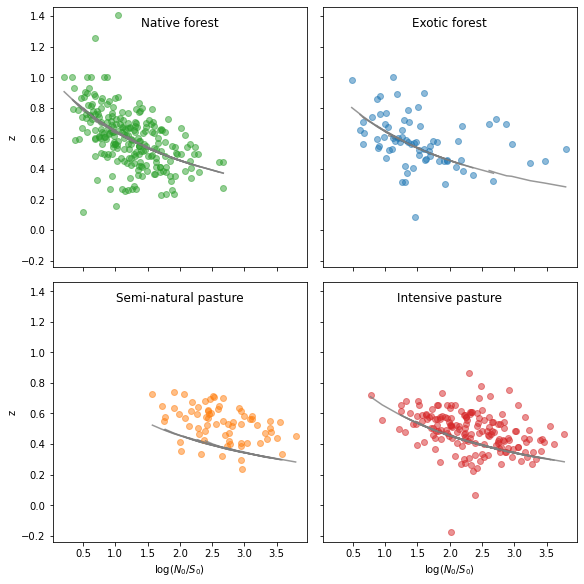

In [11]:
# Combined into one plot without residuals

fig,axs = plt.subplots(2,2,figsize=(8,8),sharex=True,sharey=True,constrained_layout=True)
#                      gridspec_kw={'height_ratios': [3,1,3,1]})

# Loop over every site
for i,site in enumerate(ls):
    # Check which land use we are in and plot accordingly
    # Exotic forest is 0,1
    if lu_ls[i]==lu[0]: 
        ax = axs[0,1]
        co = 'tab:blue'
    # Native forest is 0,0
    if lu_ls[i]==lu[1]:
        ax = axs[0,0]
        co  = 'tab:green'
    # Semi-intense pasture is 1,0
    if lu_ls[i]==lu[3]:
        ax = axs[1,0]
        co = 'tab:orange'
    # Intensive pasture is 1,1
    if lu_ls[i]==lu[2]:
        ax = axs[1,1]
        co = 'tab:red'
    # Plot observed z-D relationship
    # First get only indices where scale is OK at this site:
    inds = emp.loc[site,'s']>4
    # Then get log n/s for each scale
    logns = np.log(emp.loc[site,'n'][inds]/emp.loc[site,'s'][inds])
    
    # Plot empirical and mete z
    ax.plot(logns,emp.loc[site,'z'][inds],'o',alpha=0.5,c=co,label='Obs.')
    # Plot predicted z-D. Note x-axis is the same since we predict slope at the scale with that information
    ax.plot(logns,mete.loc[site,'z'][inds],alpha=0.8,c='tab:gray',label='METE')
    ax.set_ylim(-0.24,1.46)

# Set corresponding titles, using labels from other data sets
yheight = 0.9
axs[0,0].set_title("Native forest", y=yheight)
axs[0,1].set_title("Exotic forest", y=yheight)
axs[1,0].set_title("Semi-natural pasture", y=yheight)
axs[1,1].set_title("Intensive pasture", y=yheight)

# Labels    
axs[0,0].set_ylabel(r'z')
axs[1,0].set_ylabel(r'z')
axs[1,0].set_xlabel(r'log($N_0/S_0$)')
axs[1,1].set_xlabel(r'log($N_0/S_0$)')

fig.savefig('Figures/zD.pdf', bbox_inches='tight')

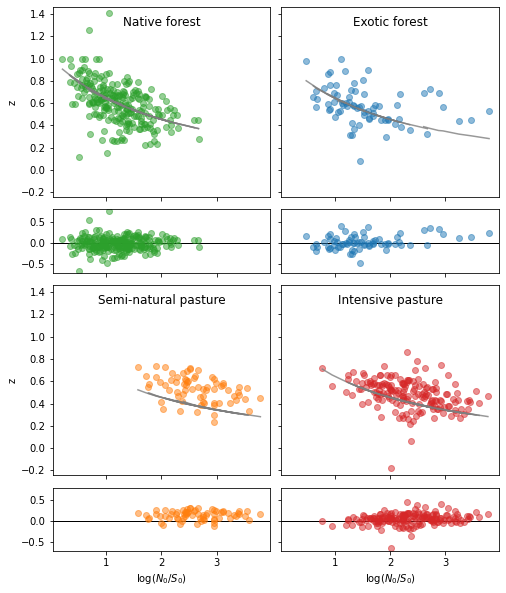

In [24]:
# Combined into one plot

fig,axs = plt.subplots(4,2,figsize=(8,10),sharex=True,#sharey=True,#constrained_layout=True,
                      gridspec_kw={'height_ratios': [3,1,3,1]})
fig.subplots_adjust(hspace=0.1)
fig.subplots_adjust(wspace=0.05)
# Make middle axis invisible since it's just for spacing

# Loop over every site
for i,site in enumerate(ls):
    # Check which land use we are in and plot accordingly
    # Exotic forest is 0,1
    if lu_ls[i]==lu[0]: 
        ax = axs[0,1]
        ax1 = axs[1,1]
        co = 'tab:blue'
    # Native forest is 0,0
    if lu_ls[i]==lu[1]:
        ax = axs[0,0]
        ax1 = axs[1,0]
        co  = 'tab:green'
    # Semi-intense pasture is 1,0
    if lu_ls[i]==lu[3]:
        ax = axs[2,0]
        ax1 = axs[3,0]
        co = 'tab:orange'
    # Intensive pasture is 1,1
    if lu_ls[i]==lu[2]:
        ax = axs[2,1]
        ax1 = axs[3,1]
        co = 'tab:red'
    # Plot observed z-D relationship
    # First get only indices where scale is OK at this site:
    inds = emp.loc[site,'s']>4
    # Then get log n/s for each scale
    logns = np.log(emp.loc[site,'n'][inds]/emp.loc[site,'s'][inds])
    
    # Plot empirical and mete z
    ax.plot(logns,emp.loc[site,'z'][inds],'o',alpha=0.5,c=co,label='Obs.')
    # Plot predicted z-D. Note x-axis is the same since we predict slope at the scale with that information
    ax.plot(logns,mete.loc[site,'z'][inds],alpha=0.8,c='tab:gray',label='METE')
    ax.set_ylim(-0.24,1.46)
    
    # Plot residuals on next axis, along with zero line
    ax1.axhline(y=0,c='k',zorder=0,lw=1) # Put this at the back
    ax1.plot(logns,emp.loc[site,'z'][inds]-mete.loc[site,'z'][inds],'o',alpha=0.5,c=co,label='Obs.')
    ax1.set_ylim(-0.7,0.8)

# Set corresponding titles, using labels from other data sets
yheight = 0.87
axs[0,0].set_title("Native forest", y=yheight)
axs[0,1].set_title("Exotic forest", y=yheight)
axs[2,0].set_title("Semi-natural pasture", y=yheight)
axs[2,1].set_title("Intensive pasture", y=yheight)

# Labels    
axs[0,0].set_ylabel(r'z')
axs[2,0].set_ylabel(r'z')
axs[3,0].set_xlabel(r'log($N_0/S_0$)')
axs[3,1].set_xlabel(r'log($N_0/S_0$)')

# Turn off for y axis for all right column
for ax in axs[:,1]:
    ax.set_yticklabels([])
#    ax.set_xticklabels([])

fig.savefig('Figures/zD_with_res.pdf', bbox_inches='tight')

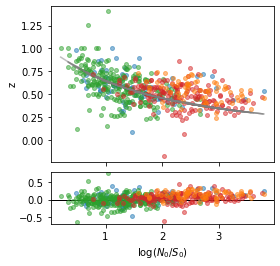

In [25]:
# All on one plot with residuals
fig,ax = plt.subplots(2,1,figsize=(4,4),gridspec_kw={'height_ratios': [3,1]})
fig.subplots_adjust(hspace=0.1)
fig.subplots_adjust(wspace=0.05)

# Loop over every site
for i,site in enumerate(ls):
    # Check which land use we are in and choose color accordingly
    # Exotic forest 
    if lu_ls[i]==lu[0]: 
        co = 'tab:blue'
    # Native forest 
    if lu_ls[i]==lu[1]:
        co = 'tab:green'
    # Semi-intense pasture
    if lu_ls[i]==lu[3]:
        co = 'tab:orange'
    # Intensive pasture
    if lu_ls[i]==lu[2]:
        co = 'tab:red'
    # Plot observed z-D relationship
    # First get only indices where scale is OK at this site:
    inds = emp.loc[site,'s']>4
    # Then get log n/s for each scale
    logns = np.log(emp.loc[site,'n'][inds]/emp.loc[site,'s'][inds])
    # Plot empirical and mete z
    ax[0].plot(logns,emp.loc[site,'z'][inds],'o',alpha=0.5,c=co,markersize=4,label='Obs.')
    # Plot predicted z-D. Note x-axis is the same since we predict slope at the scale with that information
    ax[0].plot(logns,mete.loc[site,'z'][inds],alpha=0.5,c='tab:gray',label='METE')

    # Plot residuals
    ax[1].plot(logns,emp.loc[site,'z'][inds]-mete.loc[site,'z'][inds],'o',alpha=0.5,c=co,markersize=4,label='Obs.')
    ax[1].set_ylim(-0.7,0.8)

# Other things to set
ax[1].axhline(0,c='k',zorder=0,lw=1)
ax[0].set_ylim(-0.24,1.46)
ax[1].set_ylim(-0.7,0.8) 

# Set legend
#ax.legend()

# Labels    
ax[0].set_ylabel(r'z')
ax[1].set_xlabel(r'log($N_0/S_0$)')
ax[0].set_xticklabels([])

fig.savefig('Figures/zD_oneplot_with_res.pdf', bbox_inches='tight')

### SAR relationship


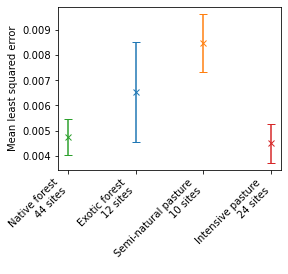

In [13]:
# Define a few things
xlist = {lu[0]:2,lu[1]:1,lu[2]:4,lu[3]:3}
clist = {lu[0]:'tab:blue',lu[1]:'tab:green',lu[2]:'tab:red',lu[3]:'tab:orange'}
lu_name = ['Exotic forest','Native forest','Intensive pasture','Semi-natural pasture']
# Plot mean and standard error of mean.
plt.figure(figsize=(4,3))
for l in lu:
    plt.errorbar(x=xlist[l],y=mean_s[l],yerr=se_s[l],fmt='x',c=clist[l],capsize=4)
plt.xticks([2,1,4,3],['{}\n{} sites'.format(lu_name[i],lu_nsites[i]) for i in np.arange(len(lu_name))],
           rotation=45,ha='right')
plt.ylabel('Mean least squared error')

plt.savefig('Figures/SI/means_SAR.pdf',bbox_inches='tight')

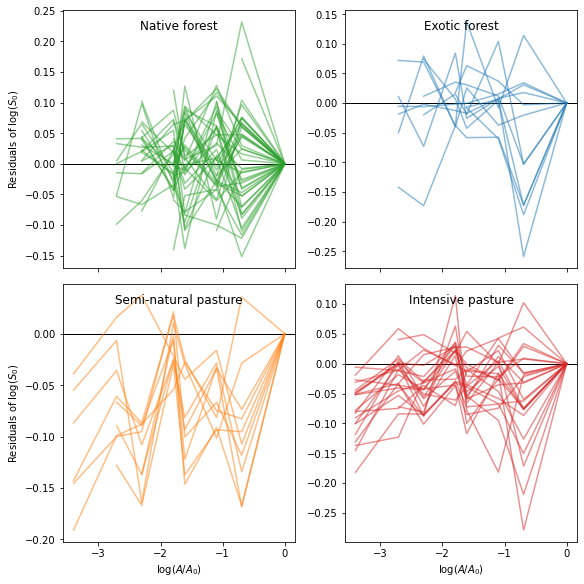

In [27]:
# Plots of all SARs for each land use
# This is pretty messy and the scale collapse one is much better

fig,axs = plt.subplots(2,2,figsize=(8,8),sharex=True,constrained_layout=True)#,sharex=True,sharey=True)

# Loop over sites
for i,site in enumerate(ls):
    # Check which land use we are in and plot accordingly
    # Exotic forest is 0,1
    if lu_ls[i]==lu[0]: 
        ax = axs[0,1]
        ct = clist[lu[0]]
    # Native forest is 0,0
    if lu_ls[i]==lu[1]:
        ax = axs[0,0]
        ct = clist[lu[1]]
    # Semi-intense pasture is 1,0
    if lu_ls[i]==lu[3]:
        ax = axs[1,0]
        ct = clist[lu[3]]
    # Intensive pasture is 1,1
    if lu_ls[i]==lu[2]:
        ax = axs[1,1]
        ct = clist[lu[2]]
    # First get only indices where scale is OK at this site:
    inds = emp.loc[site,'s']>4
    # Get maximum scale to divide x-axis by
    scalemax = emp.loc[site].index[-1]
    # Get residuals to plot
    res = np.log(emp.loc[site,'s'][inds])-np.log(mete.loc[site,'s'][inds])
    # Plot them
    ax.plot(np.log(emp.loc[site].index[inds]/scalemax),res,
            c=ct,alpha=0.5,label='Residuals')
    # Old, plot observed
#        ax.plot(np.log(emp.loc[site].index[inds]/scalemax),np.log(emp.loc[site,'s'][inds]),'o',
#                c='grey',alpha=0.5,label='Obs.')
    # Plot predicted SAR
#        ax.plot(np.log(mete.loc[site].index[inds]/scalemax),np.log(mete.loc[site,'s'][inds]),
#                c='orange',alpha=0.5,label='METE')

# Set corresponding titles
axs[0,0].set_title(lu_name[1],y=0.9)
axs[0,1].set_title(lu_name[0],y=0.9)
axs[1,0].set_title(lu_name[3],y=0.9)
axs[1,1].set_title(lu_name[2],y=0.9)

for ax in axs.flatten():
    ax.axhline(y=0,c='k',zorder=0,lw=1)

axs[0,0].set_ylabel(r'Residuals of log($S_0$)')
axs[1,0].set_ylabel(r'Residuals of log($S_0$)')
axs[1,0].set_xlabel(r'log($A/A_0$)')
axs[1,1].set_xlabel(r'log($A/A_0$)')

fig.savefig('Figures/SI/SAR.pdf', bbox_inches='tight')